<a href="https://colab.research.google.com/github/SergeyDLevashov/Impulse1/blob/main/Dephan_reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка телеметрии FC для получения значений тока и температуры

In [31]:
import re
import csv
# Блокнот предназначен для чтения файлов "телеметрии FC" CAN_1a4100fc.bin, полученных по CAN
# Путь в колабе:
#file_path = '/content/2024-03-13 KV260 Dephan morozilka test 1.txt'
file_path = '/content/CAN_1a4100fc.bin'

# у Kria есть собственное время, которое начинает отсчитываться от запуска ядра. Это время можно увидеть при старте DephSat.sh
# например:
# ьь      чР -----------DephanSatStart 42
# UART: ttyACM2; Loops: 48
# ;;;42;>>ACM2,1s;#tempr_meas ;reading;#tempr_meas
#  Temperature = 12.80C
# ;
# ;;;43;>>ACM2,0.3s;#s
# Здесь это время 42 (два раза) и 43 секунда. В последних ПЗ устойчиво сложилось, что первая команда запускается на 42 секунде
# работы Kria. Таким образом 0 (нулевая) секунда от запуска команды от БЦК будет 42 секунда на Kria
KriaDeltaTime=42+2 # 2 секунды - время инициализации фотодиода.
DefName="ПЗ 0028" # название измерения / пролета к графику фотодиода
KalugaTime="" # указывается в настройках второй части блокнота




In [34]:
def clean_and_convert_to_float(s):
    cleaned = re.sub(r"[^0-9.e-]", "", s)  # Зачистка левых символов, которые попадаются на стыке пакетов
    match = re.search(r'\d+\.\d+e-\d+', s)
    if match:
        return float(match.group())  # Возвращает найденный паттерн. re.sub все равно нужен если левые символы в середине значения
    else:
        return 0


def process_file(file_path, encoding='ISO-8859-1'):  # KOI-8 натыкается на плохие символы
    results = []
    temperature = []
    current_time = None

    with open(file_path, "r", encoding=encoding) as file:
        for line in file:
            matcht=re.match(r'^;;;(\d{2,5});>>ACM', line) # Если мы видим обращение
            if matcht:
                LastOneTime=float(matcht.group(1))-KriaDeltaTime # -42
            if line.startswith(" Temperature = "):
                current_temp_match = re.search(r" Temperature = (.+?)C?\n", line)
                temperature.append([LastOneTime, float(current_temp_match.group(1))])
            if line.startswith("(CurrTime "):
                current_time_match = re.search(r"\(CurrTime (\d+\.?\d*)", line)
                if current_time_match:
                    current_time = float(current_time_match.group(1))-KriaDeltaTime # -42
            elif line.startswith(" Current = ") and line.endswith(("A\n","A \n")):
                current_value_match = re.search(r" Current = (.+?)A?\n", line)
                #print (line,current_value_match)
                if current_value_match:
                    current_value_part = current_value_match.group(1)
                    # Отправляем только то, что в середине
                    current_value = clean_and_convert_to_float(current_value_part)
                    if current_time is not None and current_value>0:
                        current_time+=0.5
                        results.append([current_time, round(current_value*1000000,5)])

    return results,temperature

results,temperature = process_file(file_path)

with open(file_path+'.current.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(["time", "current"])
    for row in results:
        writer.writerow(row)
with open(file_path+'.temp.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(["time", "temp"])
    for row in temperature:
        writer.writerow(row)
#print ("time","current")
#for result in results:
#    print(result[0],result[1])
#print ("time","temperature")
#for tempr in temperature:
#    print(tempr[0],tempr[1])

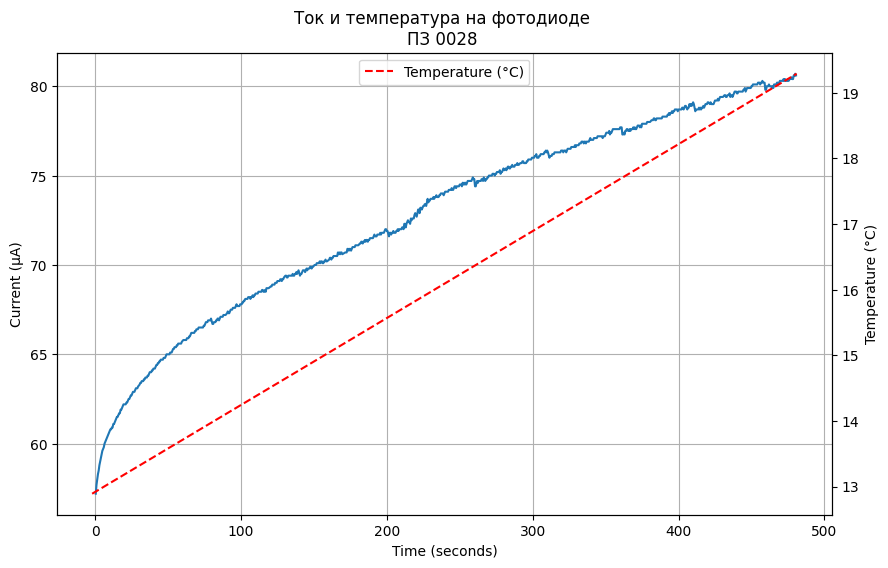

In [29]:
import matplotlib.pyplot as plt
time = [row[0] for row in results]  # время
current = [row[1] for row in results]  # ток

time2 = [row[0] for row in temperature]  # время
temp = [row[1] for row in temperature]  # температура

plt.figure(figsize=(10, 6))

# ток от времени
plt.plot(time, current, label='Current (µA)')
plt.xlabel('Time (seconds)')
plt.ylabel('Current (µA)')
plt.title('Ток и температура на фотодиоде \n'+DefName+" "+str(KalugaTime))
plt.grid(True)

#plt.xlim(250, 750)
#plt.xticks(range(2000, 3100, 100))

# температура от времени
ax2 = plt.twinx()
ax2.plot(time2, temp, label='Temperature (°C)', linestyle='--', color='r')  #
ax2.set_ylabel('Temperature (°C)')

ax2.legend(loc='upper left')
plt.legend(loc='upper center')

#lines, labels = plt.gca().get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

# 2. Отображение пролета спутника относительно точки наведения

In [ ]:
!pip install skyfield

In [ ]:
import folium
from skyfield.api import Topos, load

# Время запуска команды чтения фотодиода указано в файле .PCL например 2024-03-11__192957_VEKTOR_0028.pcl
# 11.03.2024 19:29:57   0724 {29-00-00-00-00-00-00-00}    ДОКА: Передать МИД (указатель, объем) по адресу CAN [1Б]  ()
# по этой строке задается точное время начала наблюдения. (Для карты пролёта)
# 11.03.2024 19:29:57   0724 {29-00-00-00-00-00-00-00}    ДОКА: Передать МИД (указатель, объем) по адресу CAN [1Б]  ()
# 12.03.2024 19:26:10   0724 {29-00-00-00-00-00-00-00}    ДОКА: Передать МИД (указатель, объем) по адресу CAN [1Б]  ()
KalugaTime=2024,3,12,19,26,10 # год, месяц, день, час, минута, секунда _По Калужскому ЦУП времени_

# если это команда для долгой работы с фотодиодом, то следующая команда в PCL будет существенно отличаться по времени
# например 11.03.2024 19:38:56   1150 ... итд
# Время работы фотодиода (для карты пролёта)
DephanWorkTime = 480

# Координаты наведения спутника (координаты наблюдателя для Az и на спутник)
#MyName="Калуга"
#Mylatitude = 54.5191  # широта НИЛАКТ
#Mylongitude = 36.2802  # долгота НИЛАКТ
#MyName="Руб-Эль-Хали"
#MyLatitude = 20.656  # широта
#MyLongitude = 49.944  # долгота
#MyName="Dubai Точка 1" # Море
#MyLatitude = 25.4909465
#MyLongitude = 55.2958904
MyName="Dubai Точка 2 Наб" #Набережная

#MyName="Тест из холодильника 1, коробка закрыта"
MyLatitude = 25.3631993
MyLongitude = 55.3642117

In [18]:
ground_location = Topos(latitude_degrees=MyLatitude, longitude_degrees=MyLongitude)

#03.03.2024 20:06:19   4661 {FF-00-00-00-00-00-00-00}    АПИ-ПН: Вкл по маске [9бит]  ()
#03.03.2024 20:07:09   1150 {79-03-00-00-00-00-00-00}    ДОКА: Задать указатель ИД (МИД FRAM, 128Б), канал 1  ()
#03.03.2024 20:07:10   0724 {29-00-00-00-00-00-00-00}    ДОКА: Передать МИД (указатель, объем) по адресу CAN [1Б]  ()

# Загрузка данных о спутниках и времени
ts = load.timescale()

stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle'
satellites = load.tle_file(stations_url)
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['2023-091R']  # Импульс-1

print (satellite)

# folium
m = folium.Map(location=[MyLatitude, MyLongitude], zoom_start=5)
folium.Marker([MyLatitude, MyLongitude], popup=MyName).add_to(m)

points = []
prolet = []
for offset in range(0, DephanWorkTime):
    #KalugaTime=2024,3,9,19,35,34 # задается в начале в настройках
    current_time = ts.utc(KalugaTime[0],KalugaTime[1],KalugaTime[2],KalugaTime[3]-3,KalugaTime[4],KalugaTime[5]+offset)

    difference = satellite - ground_location
    topocentric = difference.at(current_time)
    alt, az, distance = topocentric.altaz()

    #print (offset, current_time, current_time.utc_strftime()," Distance:" ,distance.km," Alt:",alt.degrees," Az:",az.degrees)

    subpoint = satellite.at(current_time).subpoint()
    lat, lon = subpoint.latitude.degrees, subpoint.longitude.degrees
    points.append((lat, lon))
    prolet.append([offset, lat,lon,alt.degrees,az.degrees,distance.km])

# нарисовать весь пролет из массива точек
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

# максимальное возвышение
max_alt_row = max(prolet, key=lambda x: x[3])
folium.PolyLine(([MyLatitude, MyLongitude],[max_alt_row[1],max_alt_row[2]]), color="grey", weight=1, opacity=0.3).add_to(m)
folium.Marker([max_alt_row[1],max_alt_row[2]],
              icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">Dist:{round(max_alt_row[5])}&nbsp;km Alt:{round(max_alt_row[3])}&nbsp;deg Offset:{max_alt_row[0]}&nbsp;sec</div>""")).add_to(m)

folium.PolyLine(([MyLatitude, MyLongitude],[prolet[0][1],prolet[0][2]]), color="grey", weight=1, opacity=0.3).add_to(m)
folium.Marker([prolet[0][1],prolet[0][2]],
              icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">Dist:{round(prolet[0][5])}&nbsp;km Alt:{round(prolet[0][3])}&nbsp;deg Offset:{prolet[0][0]}&nbsp;sec</div>""")).add_to(m)

folium.PolyLine(([MyLatitude, MyLongitude],[prolet[-1][1],prolet[-1][2]]), color="grey", weight=1, opacity=0.3).add_to(m)
folium.Marker([prolet[-1][1],prolet[-1][2]],
              icon=folium.DivIcon(html=f"""<div style="font-family: courier new; color: blue">Dist:{round(prolet[-1][5])}&nbsp;km Alt:{round(prolet[-1][3])}&nbsp;deg Offset:{prolet[-1][0]}&nbsp;sec</div>""")).add_to(m)


# Экспорт слева в файл
m.save('satellite_path.html')

m


2023-091R catalog #57181 epoch 2024-03-12 11:35:49 UTC


# 3. Совмещение данных фотодиода и положения спутника
Должны быть выполнены 1 и 2 части


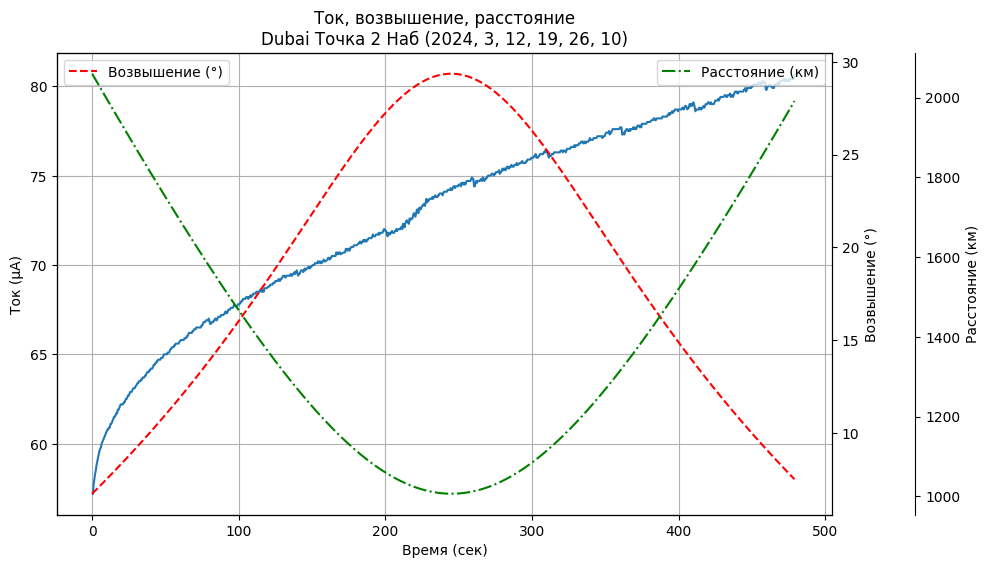

In [19]:
time = [row[0] for row in results]  # время
current = [row[1] for row in results]  # ток

time2 = [row[0] for row in prolet]  # время
alt = [row[3] for row in prolet]  # возвышение
dest = [row[5] for row in prolet] # расстояние

plt.figure(figsize=(10, 6))

# ток от времени
plt.plot(time, current, label='Ток (µA)')
plt.xlabel('Время (сек)')
plt.ylabel('Ток (µA)')
plt.title('Ток, возвышение, расстояние\n'+MyName+" "+str(KalugaTime))
plt.grid(True)

#plt.xlim(1100, 1150)
#plt.xticks(range(2000, 3100, 100))

# возвышение от времени
ax2 = plt.twinx()
ax2.plot(time2, alt, label='Возвышение (°)', linestyle='--', color='r')
ax2.set_ylabel('Возвышение (°)')


# расстояние
ax3 = plt.twinx()
ax3.plot(time2, dest, label='Расстояние (км)', linestyle='-.', color='g')
ax3.set_ylabel('Расстояние (км)')

# положение оси ax3, чтобы она не перекрывалась с ax2
ax3.spines['right'].set_position(('outward', 60))
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')

ax2.legend(loc='upper left')
ax3.legend(loc='upper right')

plt.show()